In [ ]:
# JG 4/18/18
# This workbook is for comparing BD across depth vs. BD between defining soil types.

In [209]:
import pandas as pd
import numpy as np
from skbio import stats
import skbio
import scipy.stats as scipystats


import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
%matplotlib inline


# Importing colors with palettable:
from palettable.cartocolors.qualitative import Safe_2
new_cols = [[x/255.0 for x in color] for color in Safe_2.colors]
#colorbrewer.qualitative import Set2_3

In [5]:
# Standard import:
WUF_data = pd.read_csv('../Seq_data/Updated_files/beta_WUF_diversity/WUF_dm2.txt', sep='\t',index_col=0)
current_metadata = pd.read_csv('../Metadata/ibp_metadata_4.17.18.txt', sep='\t')
                       

In [207]:
# In the cell below, I calculated BD for depth matched samples in the same or different soil types. Next I need to plot this & compare BD for samples at different depths:

In [208]:
# USDA Soil type classification:
soiltype = [''] + ['Selma loam'] * 5 + ['Hoopeston fine sandy loam'] + ['Watseka loamy fine sand']*3 + ['Hoopeston fine sandy loam']

# Data structure to store the depth matched data:
depth_matched_data = {
    'dif_soil': {},
    'same_soil': {}
}

groups = current_metadata.groupby('MicroNum')

for ind, grp in groups:

    indices = grp['SampleID'].values.tolist()
    df_subset = WUF_data.loc[indices, indices]
    # initialize empty lists to store the data
    depth_matched_data['dif_soil'][ind] = []
    depth_matched_data['same_soil'][ind] = []
    
    for i in range(len(df_subset.columns)-1):
        for j in range(i+1, len(df_subset.index)):
            sensor_1 = df_subset.columns[i].split('.')[0]
            sensor_2 = df_subset.index[j].split('.')[0]

            # Skip replicates for now
            if sensor_1 == sensor_2:
                pass
            
# For other samples, check what group they belong in and append to correct dict
            elif soiltype[int(sensor_1[1:])] == soiltype[int(sensor_2[1:])]:
                depth_matched_data['same_soil'][ind].append(df_subset.iloc[i,j])
            
            else:
                depth_matched_data['dif_soil'][ind].append(df_subset.iloc[i,j])


In [46]:
# Sanity check on the number of values I have:
# Slightly lower but it makes sense given the number of replicates
for ind, grp in groups:
    indices = grp['SampleID'].values.tolist()
    df_subset = WUF_data.loc[indices, indices]
    shape = df_subset.shape
    #print(shape)
    #print(shape[0]*(shape[0]-1)/2)
    #print(len(depth_matched_data['same_soil'][ind]))
    #print(len(depth_matched_data['dif_soil'][ind]))


In [261]:
# Calculate significance of soil type at various depths:
# Kinda cool, surfae soil characterization effects persist up to 90 cm after bonferoni correction, but not at 100-110
t_test_sig = []
for i in range(1,13):
    test = scipystats.ttest_ind(depth_matched_data['same_soil'][i], depth_matched_data['dif_soil'][i], equal_var=True)
    p_val = test[1]
    adjusted_p = p_val * 12 # Bonferoni, 10 comparisons
    t_test_sig.append(adjusted_p)
    t_test_sig_05_cutoff = ['**' if x <.05 else '' for x in t_test_sig]
    


In [336]:
# Calculating means and quartiles:
same_quart = []
dif_quart = []
for i in range(1,13):
    same_quart.append(np.percentile(depth_matched_data['same_soil'][i], [25, 50, 75]))
    dif_quart.append(np.percentile(depth_matched_data['dif_soil'][i], [25, 50, 75]))


In [255]:
depth_matched_df = pd.DataFrame(columns = ['Soil', 'Depth', 'BD'])

for depth in range(1,13):
    for soil in ['same_soil', 'dif_soil']:
        values = depth_matched_data[soil][depth]
        
        soil_vals = [soil] * len(values)
        depth_vals = [depth] * len(values)

        depth_matched_df = pd.concat([depth_matched_df, pd.DataFrame(data={'Soil':soil_vals, 'Depth':depth_vals, 'BD':values})], ignore_index=True) 

depth_matched_df['Soil'] = depth_matched_df['Soil'].map({'same_soil': 'Same USDA Soil Series', 'dif_soil': 'Different USDA Soil Series'})
depth_matched_df['Depth (cm)'] = depth_matched_df['Depth']*10

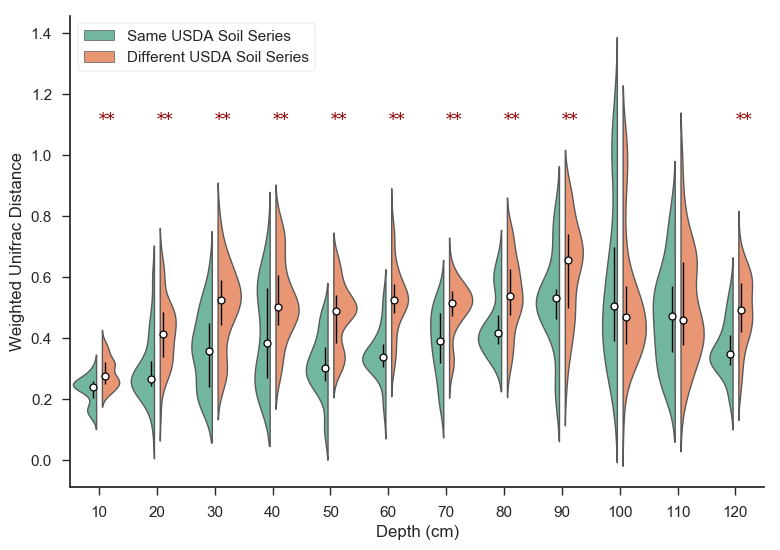

In [335]:
# Plotting depth matched BD
sns.set(font_scale=1.1)
sns.set_style({'font.sans-serif': u'Arial'})
sns.set_style('ticks')

f,ax1 = plt.subplots()
f.set_size_inches(8, 5.7)
sns.violinplot(ax = ax1, x="Depth (cm)", y="BD", hue="Soil", palette = 'Set2', legend=False, data=depth_matched_df,split=True, inner=None, linewidth=1, width=.8 )

inner = None # Note: 'box' is default
width = 0.8
delta = 0.05
final_width = width - delta
offset_violinplot_halves(ax1, delta, final_width, inner, 'vertical')

ax1.legend(loc=2, frameon=True, fancybox=True, framealpha=1)
sns.despine()
ax1.set_ylabel('Weighted Unifrac Distance')

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }
# Adding depth paired soil-type t-test significance values:
for i in range(len(t_test_sig_05_cutoff)):
    ax1.text((i),1.1, t_test_sig_05_cutoff[i], fontdict=font)


# Add means and quartiles:
for i in range(12):
    ax1.scatter(i-.1, same_quart[i][1],edgecolors='k',color='w',s=25, zorder=2, linewidth=.9)
    ax1.scatter(i+.1, dif_quart[i][1],edgecolors='k',color='w',s=25, zorder=2,linewidth=.9)
    ax1.vlines(x=i+.1, ymin=dif_quart[i][0], ymax = dif_quart[i][2], color='k', zorder=1, linewidth=1.)
    ax1.vlines(x=i-.1, ymin=same_quart[i][0], ymax = same_quart[i][2], color='k', zorder=1, linewidth=1.)

f.tight_layout()
f.savefig("../output/beta_diversity/BD_soil_and_depth.png", dpi=400, bbox_inches='tight' )

In [96]:
# What am I most interested in? From a few of the papers that specifically analyzed depth, we know that small depth differences can have effects similar to major spatial variation. Is this the case here?
#outline: 
# 1. group by well, then look at delta BD/depth within a well.
# 2. group by soiltype (essentially looking at combination of soiltype etcp., then look at delta BD/depth within soil type classification
# 3. 

In [204]:
def offset_violinplot_halves(ax, delta, width, inner, direction):
    """
    This function offsets the halves of a violinplot to compare tails
    or to plot something else in between them. This is specifically designed
    for violinplots by Seaborn that use the option `split=True`.

    For lines, this works on the assumption that Seaborn plots everything with
     integers as the center.

    Args:
     <ax>    The axis that contains the violinplots.
     <delta> The amount of space to put between the two halves of the violinplot
     <width> The total width of the violinplot, as passed to sns.violinplot()
     <inner> The type of inner in the seaborn
     <direction> Orientation of violinplot. 'hotizontal' or 'vertical'.

    Returns:
     - NA, modifies the <ax> directly
    """
    # offset stuff
    if inner == 'sticks':
        lines = ax.get_lines()
        for line in lines:
            if direction == 'horizontal':
                data = line.get_ydata()
                print(data)
                if int(data[0] + 1)/int(data[1] + 1) < 1:
                    # type is top, move neg, direction backwards for horizontal
                    data -= delta
                else:
                    # type is bottom, move pos, direction backward for hori
                    data += delta
                line.set_ydata(data)
            elif direction == 'vertical':
                data = line.get_xdata()
                print(data)
                if int(data[0] + 1)/int(data[1] + 1) < 1:
                    # type is left, move neg
                    data -= delta
                else:
                    # type is left, move pos
                    data += delta
                line.set_xdata(data)


    for ii, item in enumerate(ax.collections):
        # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
            # get path
            path, = item.get_paths()
            vertices = path.vertices
            half_type = _wedge_dir(vertices, direction)
            # shift x-coordinates of path
            if half_type in ['top','bottom']:
               if inner in ["sticks", None, 'quartile']:
                    if half_type == 'top': # -> up
                        vertices[:,1] -= delta
                    elif half_type == 'bottom': # -> down
                        vertices[:,1] += delta
            elif half_type in ['left', 'right', 'quartile']:
                if inner in ["sticks", None]:
                    if half_type == 'left': # -> left
                        vertices[:,0] -= delta
                    elif half_type == 'right': # -> down
                        vertices[:,0] += delta

def _wedge_dir(vertices, direction):
    """
    Args:
      <vertices>  The vertices from matplotlib.collections.PolyCollection
      <direction> Direction must be 'horizontal' or 'vertical' according to how
                   your plot is laid out.
    Returns:
      - a string in ['top', 'bottom', 'left', 'right'] that determines where the
         half of the violinplot is relative to the center.
    """
    if direction == 'horizontal':
        result = (direction, len(set(vertices[1:5,1])) == 1)
    elif direction == 'vertical':
        result = (direction, len(set(vertices[-3:-1,0])) == 1)
    outcome_key = {('horizontal', True): 'bottom',
                   ('horizontal', False): 'top',
                   ('vertical', True): 'left',
                   ('vertical', False): 'right'}
    # if the first couple x/y values after the start are the same, it
    #  is the input direction. If not, it is the opposite
    return outcome_key[result]

